## Convex optimization

We can state a general nonlinear optimization problem in the form

\begin{align}
\min \quad&f(x)\\
\text{s.t.} \quad& g(x) = 0, \\
& h(x) \leq 0.
\end{align}

When should we expect to be able to solve to a globally optimal solution efficiently? When $f$ and $h$ are **convex** and $g$ is **affine**.

### Detecting convexity

A function $f: \mathbb{R}^n \to \mathbb{R}$ is convex iff $f(\theta x + (1-\theta)y) \leq \theta f(x) + (1-\theta)f(y), \forall x,y \in \mathbb{R}^n \text{ and } \theta \in [0,1]$.

Given an arbitrary function $f$, detecting if $f$ is convex is [NP-Hard](http://web.mit.edu/~a_a_a/Public/Publications/convexity_nphard.pdf). So how do we know if a problem is convex?

A reasonable approach is to make sure that a model is built-up in a manner that lets us prove convexity by using a calculus of convex analysis; this is  **Disciplined Convex Programming** (DCP).

We start with operations that are known to be convex:
- Norms (why?)
- $\exp(\cdot)$
- $-\log(\cdot)$
- $x^p$ for $p \geq 1$ and $x \geq 0$.
- $1/x$ for $x > 0$
- $x^2$
- ...

Then add composition rules, e.g., $f(g(\cdot))$ is convex when $f$ is convex and
- $g$ is linear or affine
- $f$ is monotonic increasing and $g$ is convex

Also, $f_1+f_2$ and $\max\{f_1,f_2\}$ are convex when $f_1$ and $f_2$ are convex.

So our previous example of $x^2 - \log(x)$ is convex by these rules, because it is the sum of convex functions. So is $\max\{e^x,1/x\}$ ([plot](http://www.wolframalpha.com/input/?i=max%28exp%28x%29%2C1%2Fx%29+for+x+%3E+0)).

Note that these rules are *sufficient* but not *necessary* to prove convexity. 

There are a lot of existing materials on DCP which we won't try to reproduce here. Let's head over to http://dcp.stanford.edu/.

>**\[Exercise\]**: DCP Quiz

> Play the [DCP quiz](http://dcp.stanford.edu/quiz). Turn up the difficulty to hard for extra fun!

### Solving "DCP-compliant" problems

DCP rules are useful not just for proving convexity, but also for *solving* the problems.

For example, we (should) know that the following problem
\begin{align}
\min \quad& {||}x||_1\\
\text{s.t.} \quad& Ax = b, \\
& x \geq 0,
\end{align}

where $||x||_1 = \sum_i |x_i|$ can be solved by using linear programming.

Just introduce auxiliary variables $z$ and solve
\begin{align}
\min \quad& \sum_i z_i\\
\text{s.t.} \quad&z_i \geq x_i, \forall i\\
& z_i \geq -x_i, \forall i\\
& Ax = b, \\
& x \geq 0,
\end{align}

Similarly
\begin{align}
\min \quad& {||}x||_\infty\\
\text{s.t.} \quad& Ax = b, \\
& x \geq 0,
\end{align}

where $||x||_\infty = \max\{|x_1|,\cdots,|x_n|\}$ can be formulated as

\begin{align}
\min \quad& z\\
\text{s.t.} \quad&z \geq x_i, \forall i\\
& z \geq -x_i, \forall i\\
& Ax = b, \\
& x \geq 0,
\end{align}

(What do we do when $||\cdot||_1$ and $||\cdot||_\infty$ appear in convex constraints?)

Given these results, we might say that $||\cdot||_1$ and $||\cdot||_\infty$ are *LP-representable*, in a sense that can be made rigorous.

What about $||\cdot||_2$? It's SOCP (second-order conic programming) representable, since
$$
||x||_2 \leq t
$$
is precisely a second-order conic constraint that's already supported by Gurobi, CPLEX, MOSEK, ECOS, SCS, ...

What about $1/x$? It's also SOCP representable since
$$
1/x \leq t
$$
iff
$$
||(2,x-t)||_2 \leq x+t.
$$

It turns out that [A LOT](http://docs.mosek.com/generic/modeling-letter.pdf) of common convex functions are SOCP-representable.

Once we know how to represent basic operations using LPs or SOCPs, we can easily compose them. For example, we would represent

\begin{align}
\min \quad& \max\{||Cx-d||,1/x_1\}\\
\text{s.t.} \quad& Ax = b, \\
& x \geq 0,
\end{align}

as

\begin{align}
\min \quad& t\\
\text{s.t.} \quad& t \geq z_1 \\
&t \geq z_2\\
&{||}Cx-d|| \leq z_1\\
&{||}(2,x_1-z_2)|| \leq x_1+z_2\\
& Ax = b, \\
& x \geq 0,
\end{align}

and hand the problem off to Gurobi as an SOCP.

### DCP in summary

- Represent the model in a way that makes it easy to use DCP rules to prove convexity.
- Break down the individual pieces into parts that are representable using LP, SOCP, semidefinite programming, (or exponential cones)
- Use composition rules to *automatically* generate a complete formulation that can be given to existing solvers
- Note that derivatives aren't used anywhere!

The first implementation of DCP was [CVX](http://cvxr.com/cvx/) in MATLAB. More recently, it's been implemented in [cvxpy](https://github.com/cvxgrp/cvxpy) and [Convex.jl](https://github.com/JuliaOpt/Convex.jl).

## Support Vector Machines (SVM)

[Support vector machines](http://en.wikipedia.org/wiki/Support_vector_machine) is (was?) a popular model in machine learning for classification. We'll use this example to illustrate the basic use of Convex.jl for solving nontrivial convex optimization problems.

The basic problem is that we are given a set of N points $x_1,x_2,\ldots, x_N \in \mathbb{R}^n$ and labels $y_1, y_2, \ldots, y_n \in \{-1,+1\}$. And we want to find a hyperplane of the form $w^Tx-b = 0$ that *separates* the two classes, i.e. $w^Tx_i - b \geq 1$ when $y_i = +1$ and $w^Tx_i - b \leq -1$ when $y_i = -1$. This condition can be written as $y_i(w^Tx_i - b) \geq 1, \forall\, i$.

Such a hyperplane will not exist in general if the data overlap, so instead we'll just try to minimize violations of the constraint $y_i(w^Tx_i - b) \geq 1, \forall\, i$ by adding a penalty when it is violated. The optimization problem can be stated as
$$
\min_{w,b} \sum_{i=1}^N \left[\max\{0, 1 - y_i(w^Tx_i - b)\}\right] + \gamma ||w||_2^2
$$
Note that we penalize the norm of $w$ in order to guarantee a unique solution.

Now let's write our own SVM solver!

In [1]:
using Distributions
using PyPlot
using Convex
using Gurobi

In [2]:
# Function to generate some random test data
function gen_data(N)
    # for +1 data, symmetric multivariate normal with center at (1,2)
    pos = rand(MvNormal([1.0,2.0],1.0),N)
    # for -1 data, symmetric multivariate normal with center at (-1,1)
    neg = rand(MvNormal([-3.0,1.0],1.0),N)
    x = [pos neg]
    y = [fill(+1,N);fill(-1,N)]
    return x,y
end

gen_data (generic function with 1 method)

Let's see what the data look like.

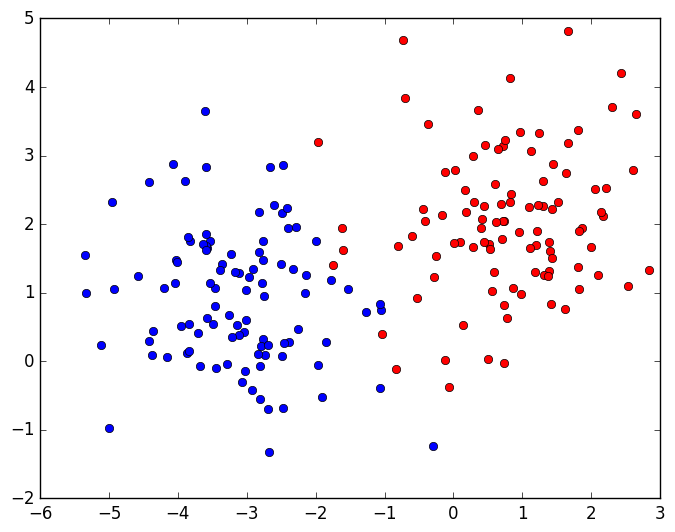

In [3]:
x,y = gen_data(100)
plot(x[1,1:100], x[2,1:100], "ro", x[1,101:200], x[2,101:200], "bo");

Now we translate the optimization problem into Convex.jl form.

In [4]:
const γ = 0.005
function svm(x,y)
    n = size(x,1) # problem dimension
    N = size(x,2) # number of points
    w = Variable(n)
    b = Variable()
    
    problem = minimize( γ*sumsquares(w) + sum(max(1-y.*(x'*w-b),0)))
    solve!(problem, GurobiSolver(OutputFlag=0))
    return evaluate(w), evaluate(b)
end

svm (generic function with 1 method)

In [5]:
N = 500
x,y = gen_data(N)

w,b = svm(x,y)

(size(coeff),size(var)) = ((1000,1),(1000,1))


(
[2.52011; 0.819778],

-1.3450427640530844)

And the solution?

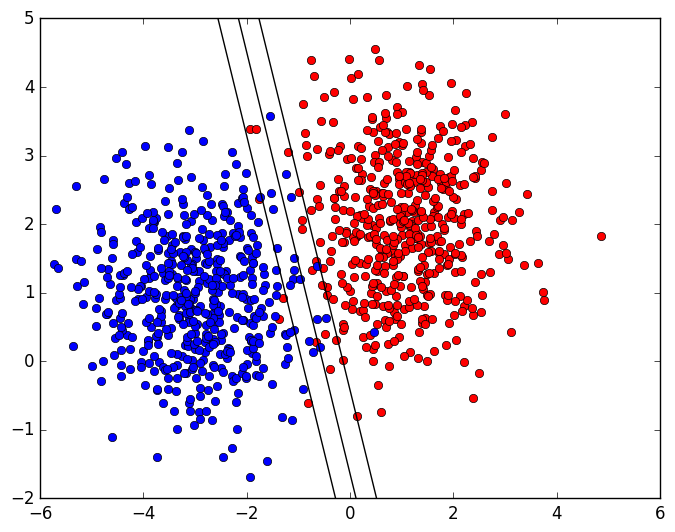

In [6]:
plot(x[1,1:N], x[2,1:N], "ro", x[1,(N+1):2N], x[2,(N+1):2N], "bo");

xmin, xmax = xlim()
ymin, ymax = ylim()
y1 = (1+b-w[1]*xmin)/w[2]
y2 = (1+b-w[1]*xmax)/w[2]
plot([xmin,xmax], [y1,y2], "k-");
y1 = (-1+b-w[1]*xmin)/w[2]
y2 = (-1+b-w[1]*xmax)/w[2]
plot([xmin,xmax], [y1,y2], "k-");
y1 = (b-w[1]*xmin)/w[2]
y2 = (b-w[1]*xmax)/w[2]
ylim(ymin,ymax)
plot([xmin,xmax], [y1,y2], "k-");

>**\[Exercise\]**: Sensitivity

> Increase the separation between the positive and negative data by modifying the means in ``gen_data``. How does the solution change?


## Discussion
- Convex.jl vs. JuMP.jl
- Derivative-based nonlinear vs. automatic transformation to LP/SOCP/conic form